In [207]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA


In [208]:
historic_df = pd.read_csv(r'Base de Dados//Dados Históricos - Ibovespa.csv', parse_dates=['Data'], index_col='Data')

historic_df['Var%'] = historic_df['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)

historic_df['Vol.'] = historic_df['Vol.'].str.replace(',', '.')
historic_df['Vol.'] = historic_df['Vol.'].apply(
    lambda x: float(str(x)[:-1].replace(',', '.'))/1_000  if str(x)[-1] == 'K'
    else float(str(x)[:-1].replace(',', '.')) if str(x)[-1] == 'M'
    else float(str(x)[:-1].replace(',', '.')) * 1_000 if str(x)[-1] == 'B'
    else float(str(x).replace(',', '.'))/1_000_000 )

historic_df.rename(columns={'Vol.':'Vol (M)'}, inplace=True)

C:\Users\dhlui\AppData\Local\Temp\ipykernel_12060\1969224291.py:1: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  historic_df = pd.read_csv(r'Base de Dados//Dados Históricos - Ibovespa.csv', parse_dates=['Data'], index_col='Data')


In [209]:
historic_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2529 entries, 2025-03-14 to 2015-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    2529 non-null   float64
 1   Abertura  2529 non-null   float64
 2   Máxima    2529 non-null   float64
 3   Mínima    2529 non-null   float64
 4   Vol (M)   2528 non-null   float64
 5   Var%      2529 non-null   float64
dtypes: float64(6)
memory usage: 138.3 KB


In [210]:
historic_df.describe()

,Último,Abertura,Máxima,Mínima,Vol (M),Var%
count,2529.000000,2529.000000,2529.000000,2529.000000,2528.000000,2529.000000
mean,92.832769,92.802186,93.633868,91.996363,200.536119,0.048909
std,27.161430,27.165028,27.275906,27.042717,1451.574298,1.505227
min,37.497000,37.501000,38.031000,37.046000,0.424320,-14.780000
25%,67.069000,67.000000,67.623000,66.452000,3.800000,-0.730000
50%,100.270000,100.262000,101.296000,99.365000,6.670000,0.060000
75%,115.662000,115.652000,116.672000,114.730000,10.772500,0.860000
max,137.344000,137.349000,137.469000,136.664000,24870.000000,13.910000


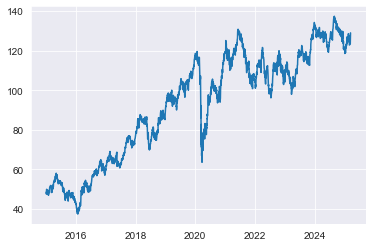

In [211]:
plt.plot(historic_df.index, historic_df['Último'])

In [212]:
historic_var_df = historic_df[['Último']]
X = historic_var_df[['Último']].values


In [213]:
# Teste utilizando valores brutos de fechamento
result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -0.9917012747714095
P-Value: 0.7562790236239734
Valores críticos:
	1%: -3.4329476085791493
	5%: -2.8626876136761292
	10%: -2.5673809185248175


Teste ADF
Teste Estatístico: -9.18059136497803
P-Value: 2.257540079936746e-15
Valores críticos:
	1%: -3.4329810529006184
	5%: -2.862702382731847
	10%: -2.5673887817601657


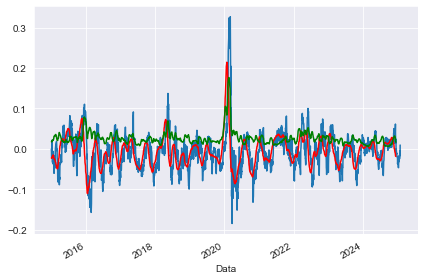

In [214]:
# Teste utilizando logaritimos dos últimos 30 dias

df_log = np.log(historic_var_df)
ma_log = df_log.rolling(30).mean()

df_s = (df_log - ma_log).dropna()

ma_s = df_s.rolling(30).mean()

std = df_s.rolling(30).std()

f, ax = plt.subplots()
df_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
plt.tight_layout()


X_s = df_s['Último'].values
result_s = adfuller(X_s)

print("Teste ADF")
print(f"Teste Estatístico: {result_s[0]}")
print(f"P-Value: {result_s[1]}")
print("Valores críticos:")

for key, value in result_s[4].items():
  print(f"\t{key}: {value}")

In [233]:
df_diff.shape

(2500, 1)

Teste ADF
Teste Estatístico: -13.024226574688145
P-Value: 2.4183283121208144e-24
Valores críticos:
	1%: -3.4329959571307342
	5%: -2.8627089644059445
	10%: -2.5673922859370437


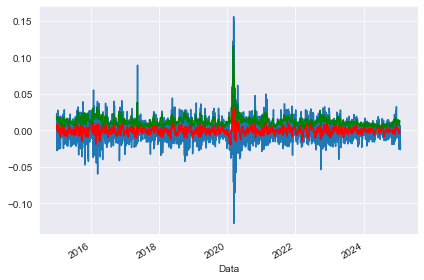

In [232]:
# Teste utilizando desvio padrão
df_diff = df_s.diff(1)
ma_diff = df_diff.rolling(7).mean()

std_diff = df_diff.rolling(7).std()


f, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

X_diff = df_diff['Último'].dropna().values
result_diff = adfuller(X_diff)

print("Teste ADF")
print(f"Teste Estatístico: {result_diff[0]}")
print(f"P-Value: {result_diff[1]}")
print("Valores críticos:")

for key, value in result_diff[4].items():
  print(f"\t{key}: {value}")

In [216]:
lag_acf = acf(df_diff.dropna(), nlags=25)
lag_acf


array([ 1.00000000e+00, -1.02585530e-01,  3.96474136e-02,  5.90459238e-03,
       -3.26120451e-02,  4.76653438e-02, -7.83542324e-02,  8.73338524e-02,
       -2.39569238e-02,  2.14839030e-02,  2.25881904e-02,  8.07235261e-03,
       -3.32139777e-03, -5.20569269e-02,  2.40603989e-02, -4.43051269e-02,
       -1.02511452e-02,  4.21607261e-04, -2.56862558e-02, -3.83488235e-02,
       -4.51243279e-02, -5.18179237e-03, -2.94813188e-02, -5.04281801e-02,
       -1.93089570e-02, -4.36185709e-02])

In [217]:
lag_pacf = pacf(df_diff.dropna(), nlags=25)
lag_pacf

array([ 1.        , -0.1026266 ,  0.0294572 ,  0.01303545, -0.0323295 ,
        0.04113204, -0.06851288,  0.07209637, -0.00587871,  0.01763123,
        0.02047329,  0.02181705, -0.0145626 , -0.04317591,  0.00778165,
       -0.03568986, -0.02005556, -0.00313957, -0.02429618, -0.05271065,
       -0.04385952, -0.01879462, -0.02469164, -0.05415976, -0.02944167,
       -0.04653354])

In [234]:
df_diff

,Último
Data,
2025-01-30,NaN
2025-01-29,-0.026352
2025-01-28,0.005465
2025-01-27,0.006209
2025-01-24,-0.019244
...,...
2015-01-08,0.023214
2015-01-07,-0.008482
2015-01-06,-0.027791


In [259]:
data = df_diff.copy()
data.rename(columns={'Último':'y'}, inplace=True)
data['ds'] = data.index
data['unique_id'] = '-'

treino = data.loc[data.index < '2025-01-01']
valid = data.loc[(data.index >= '2025-01-01')]

h = valid['ds'].nunique()

h

21

In [255]:
def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

WMAPE: nan%


KeyError: 'index-lo-90'

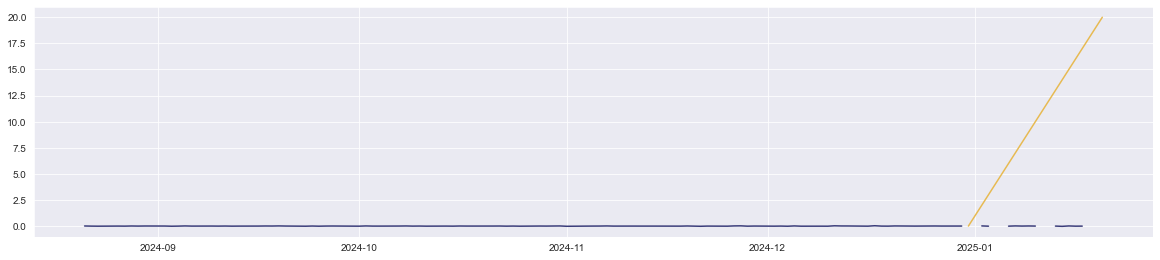

In [261]:

model = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model.fit(treino)

forecast_df = model.predict(h=h, level=[90])
forecast_df = forecast_df.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape1 = wmape(forecast_df['y'].values, forecast_df['Naive'].values)
print(f"WMAPE: {wmape1:.2%}")

model.plot(treino, forecast_df, level=[90],engine ='matplotlib', max_insample_length=90)


In [257]:
model

StatsForecast(models=[Naive])